# Data collection

In [2]:
!pip install geopy
!pip install plotly
!pip install librosa
!pip install pydub

In [3]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import seaborn as sns
import os
import urllib.request
import plotly.express as px
from geopy.distance import distance
import plotly.graph_objects as pgo
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import Audio
from pydub import AudioSegment
from scipy.io import wavfile
from tempfile import mktemp

In [4]:
def get_data():
    birds_df = pd.DataFrame()
    for page in range(130):
        html = f'https://xeno-canto.org/api/2/recordings?query=cnt:brazil&page={page+1}'
        print(f'requesting page {page+1}')
        response = requests.get(html).json()
        new_df = pd.DataFrame(response['recordings'])
        birds_df = pd.concat([birds_df, new_df], ignore_index=True)
    return birds_df
def save_csv(df,name):
    path = os.path.expanduser(f'~/{name}.csv')
    df.to_csv(path, index = False)

In [5]:
birds_df = get_data()
birds_df.shape

requesting page 1
requesting page 2
requesting page 3
requesting page 4
requesting page 5
requesting page 6
requesting page 7
requesting page 8
requesting page 9
requesting page 10
requesting page 11
requesting page 12
requesting page 13
requesting page 14
requesting page 15
requesting page 16
requesting page 17
requesting page 18
requesting page 19
requesting page 20
requesting page 21
requesting page 22
requesting page 23
requesting page 24
requesting page 25
requesting page 26
requesting page 27
requesting page 28
requesting page 29
requesting page 30
requesting page 31
requesting page 32
requesting page 33
requesting page 34
requesting page 35
requesting page 36
requesting page 37
requesting page 38
requesting page 39
requesting page 40
requesting page 41
requesting page 42
requesting page 43
requesting page 44
requesting page 45
requesting page 46
requesting page 47
requesting page 48
requesting page 49
requesting page 50
requesting page 51
requesting page 52
requesting page 53
re

(64722, 38)

# Data processing

In [6]:
# Processing the latitudes and longitudes
birds_df['lat'] = pd.to_numeric(birds_df['lat'])
birds_df['lng'] = pd.to_numeric(birds_df['lng'])

In [7]:
# Cleaning null and "na" values
birds_df = birds_df[(birds_df['lat'] != 0) & (birds_df['lng'] != 0)]
birds_df = birds_df.dropna()

In [8]:
# Focus on a radius of 500km around Rio de Janeiro (Brazil)
point = (-22.91216,-43.17501)
distance_km = 500

rio_df = birds_df[birds_df.apply(lambda row: distance(point, (row['lat'], row['lng'])).km <= distance_km, axis=1)]

In [9]:
# Creating a column merging generic and specific name of the birds
rio_df['gen_sp'] = rio_df['gen'] + ' ' + rio_df['sp']
birds_df['gen_sp'] = birds_df['gen'] + ' ' + birds_df['sp']

/var/folders/cj/2_2l_4tx565dryhmb022px3r0000gn/T/ipykernel_41450/2782024953.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rio_df['gen_sp'] = rio_df['gen'] + ' ' + rio_df['sp']


In [10]:
# Taking all those species observed <500km from Rio and keeping those where we have > 100 recordings
rio_sp = rio_df['gen_sp'].unique()
birds_df_filt = birds_df[birds_df['gen_sp'].isin(rio_sp)]
counts = birds_df_filt['gen_sp'].value_counts()
filtered_df = birds_df_filt[birds_df_filt['gen_sp'].isin(counts[counts > 100].index)]

In [11]:
# Removing unknown birds
filtered_df = filtered_df[filtered_df['gen_sp'] != 'Mystery mystery']

In [12]:
# Processing the index
filtered_df.reset_index(drop=True,inplace=True)

Final dataset ready

# Data exploration

View on our table:

In [13]:
filtered_df.head(1)

id           gen    sp ssp  group              en                 rec  \
0  524786  Crypturellus  soui      birds  Little Tinamou  Guilherme Willrich   

      cnt                               loc     lat  ...  bird-seen  \
0  Brazil  Canaã dos Carajás, State of Pará -6.3112  ...         no   

  animal-seen playback-used temp regnr auto dvc mic    smp             gen_sp  
0          no            no              no          48000  Crypturellus soui  

[1 rows x 39 columns]

In [32]:
filtered_df.to_csv('filtered_df.csv', index=False)

Recordings grouped by species:

In [15]:
summary_table = filtered_df.groupby('gen_sp').count().sort_values(by='id', ascending = False)[['id']]
total_recordings = summary_table['id'].sum()
summary_table.loc['Total'] = total_recordings
summary_table

id
gen_sp                          
Turdus rufiventris           296
Cyclarhis gujanensis         260
Tolmomyias sulphurescens     258
Sittasomus griseicapillus    215
Chiroxiphia caudata          209
...                          ...
Donacobius atricapilla       101
Pionus maximiliani           101
Thamnophilus ambiguus        101
Aramides cajaneus            101
Total                      16335

[122 rows x 1 columns]

Explanation of each features (source = Xeno Canto website):

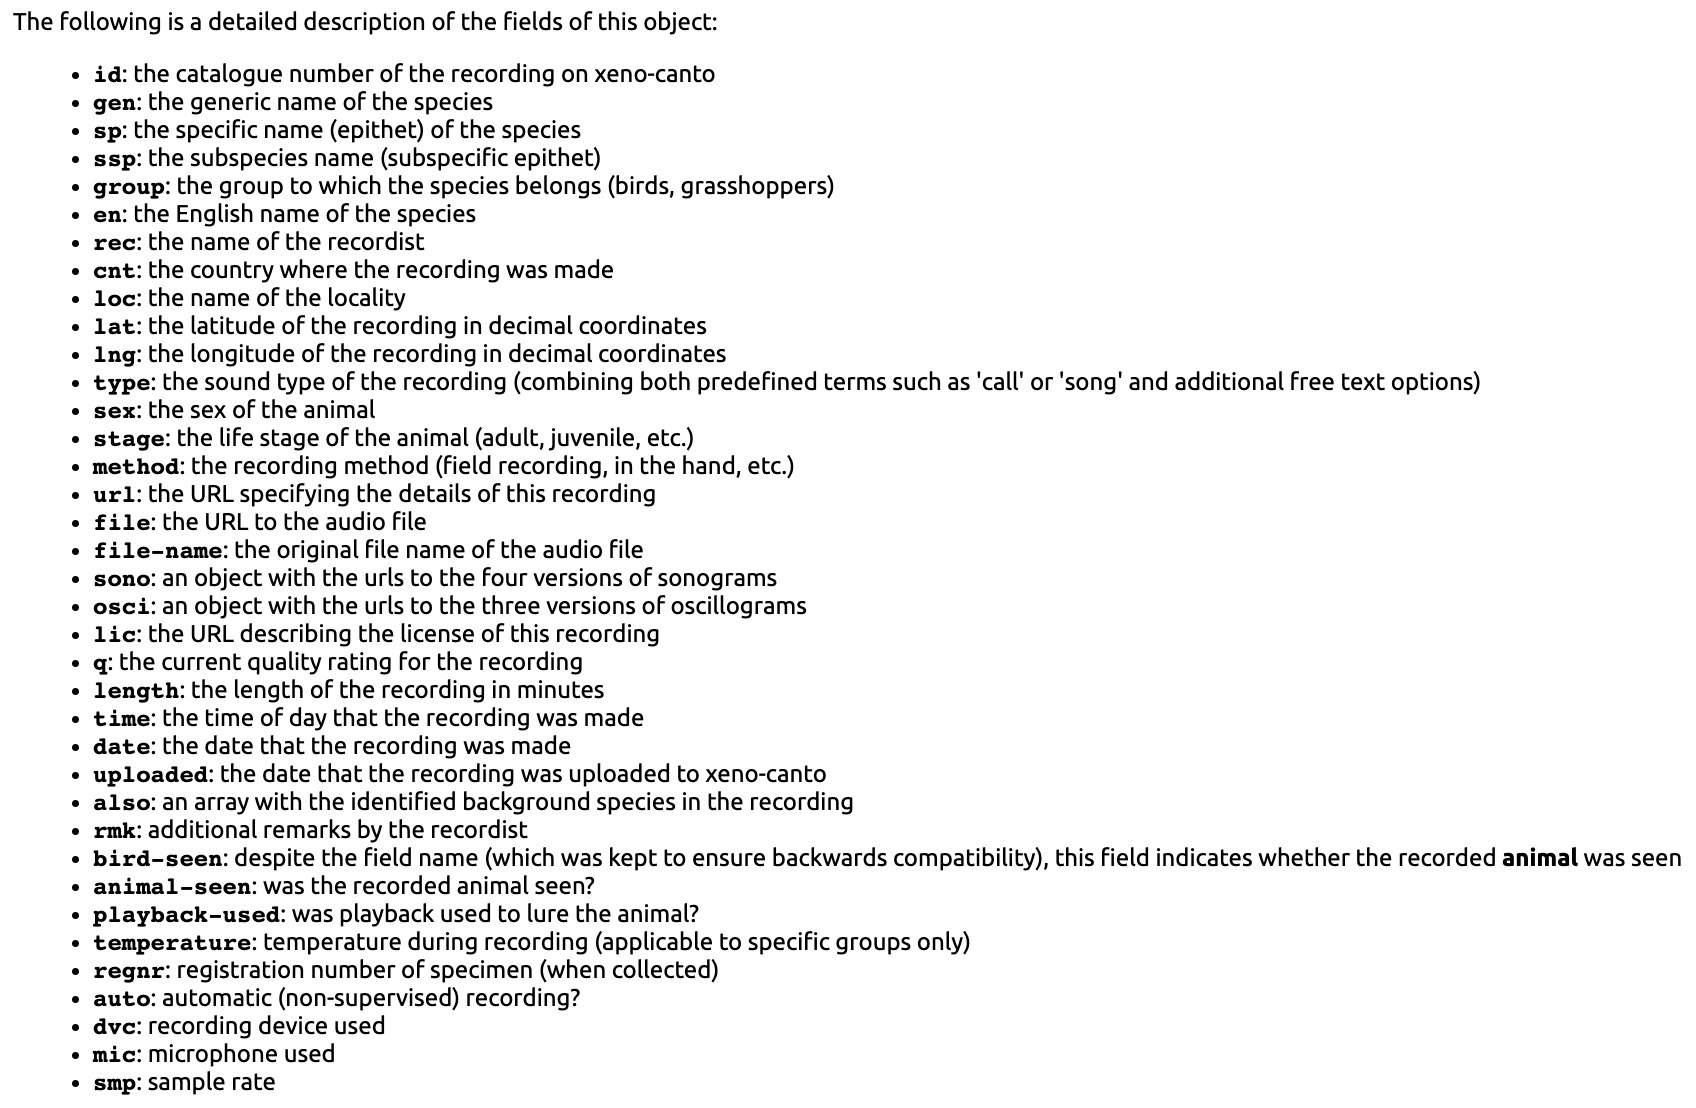

In [16]:
from IPython import display
display.Image("/Users/rodolpheterlinden/Desktop/Rodolphe/Projects/Wagon/imgbird.jpg")

# Data analysis

## Quality of the recordings

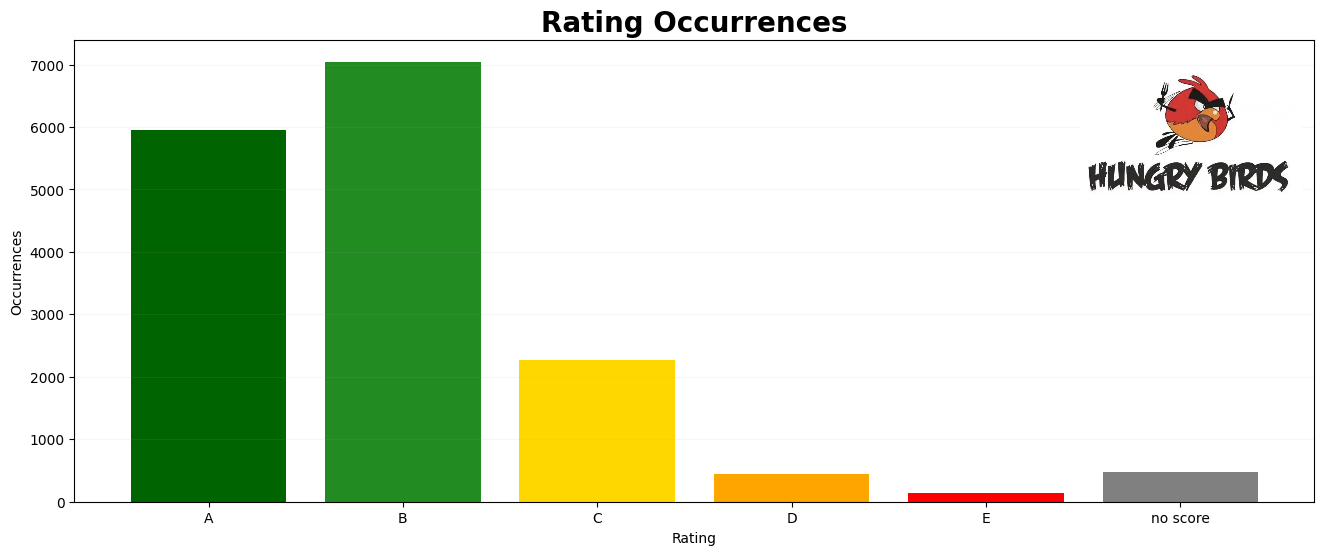

In [17]:
bird = mpimg.imread('/Users/rodolpheterlinden/Desktop/Rodolphe/Projects/Wagon/hb.jpg')
fig, ax = plt.subplots(figsize=(16, 6))


im = OffsetImage(bird, zoom=0.23)
ab = AnnotationBbox(im, xy=(0.90, 0.80), xycoords='axes fraction', frameon=False)
ax.add_artist(ab)



ratings = filtered_df['q'].values.tolist()
occurrences = [ratings.count('A'), ratings.count('B'), ratings.count('C'), ratings.count('D'), ratings.count('E'),ratings.count('no score')]
colors = ['darkgreen', 'forestgreen', 'gold', 'orange', 'red', 'gray']
plt.grid(axis='y', alpha=0.1)

plt.bar(['A', 'B', 'C', 'D','E','no score'], occurrences, color=colors)

plt.title('Rating Occurrences', fontsize=20, fontweight='bold')
plt.xlabel('Rating')
plt.ylabel('Occurrences')
plt.show()

In [18]:
d_ratings = filtered_df.loc[filtered_df['q'] == 'E']

# select a random row from the filtered dataframe
random_row = d_ratings.sample()

# print the selected row
print(random_row["url"])

5647    //xeno-canto.org/172970
Name: url, dtype: object


In [19]:
url_A = "/Users/rodolpheterlinden/code/Tfcosendey/hungry_birds/raw_data/songs/Dysithamnus mentalis/80065.mp3"
print("URL A-quality")
Audio(filename=url_A)

URL A-quality


In [20]:
url_D = "/Users/rodolpheterlinden/code/Tfcosendey/hungry_birds/raw_data/songs/Gnorimopsar chopi/561995.mp3"
Audio(filename=url_D)

**Findings**: We might consider skipping the lowest quality recordings for our analysis

## Number of recordings over time

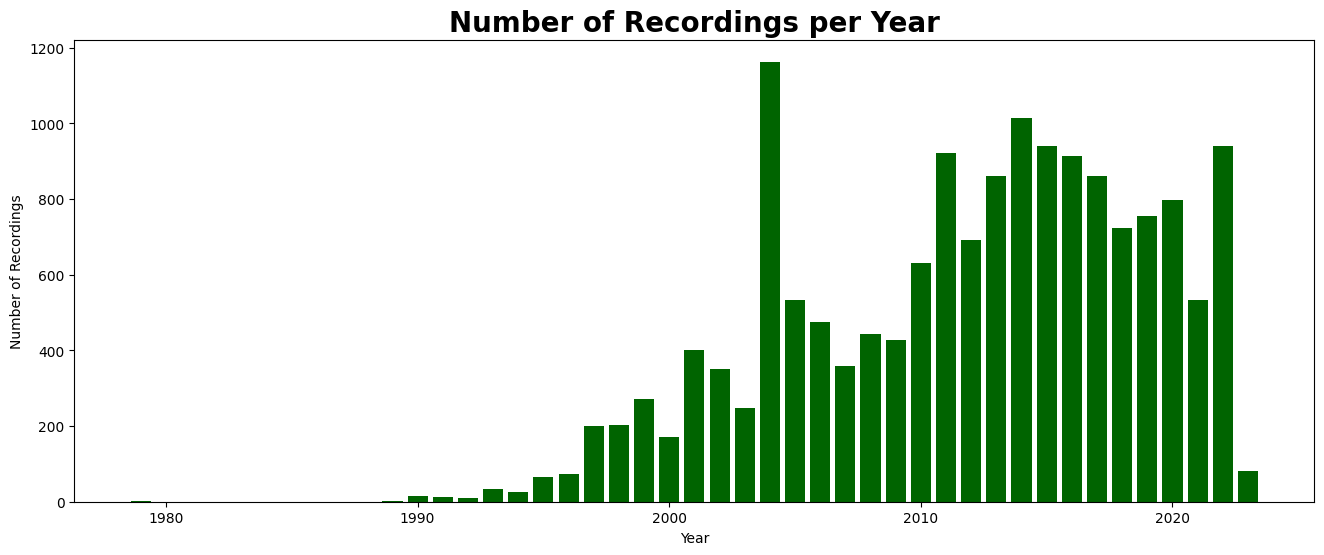

In [21]:
fig, ax = plt.subplots(figsize=(16, 6))

filtered_df['date'] = pd.to_datetime(filtered_df['date'], format='%Y-%m-%d', errors='coerce')
filtered_df['year'] = filtered_df['date'].dt.year
year_counts = filtered_df['year'].value_counts()
plt.bar(year_counts.index, year_counts.values, color = "darkgreen")

plt.xlabel('Year')
plt.ylabel('Number of Recordings')
plt.title('Number of Recordings per Year', fontsize=20, fontweight='bold')

plt.show()

**Findings**: We have a consistent number of recordings uploaded overtime

## Length of the recordings

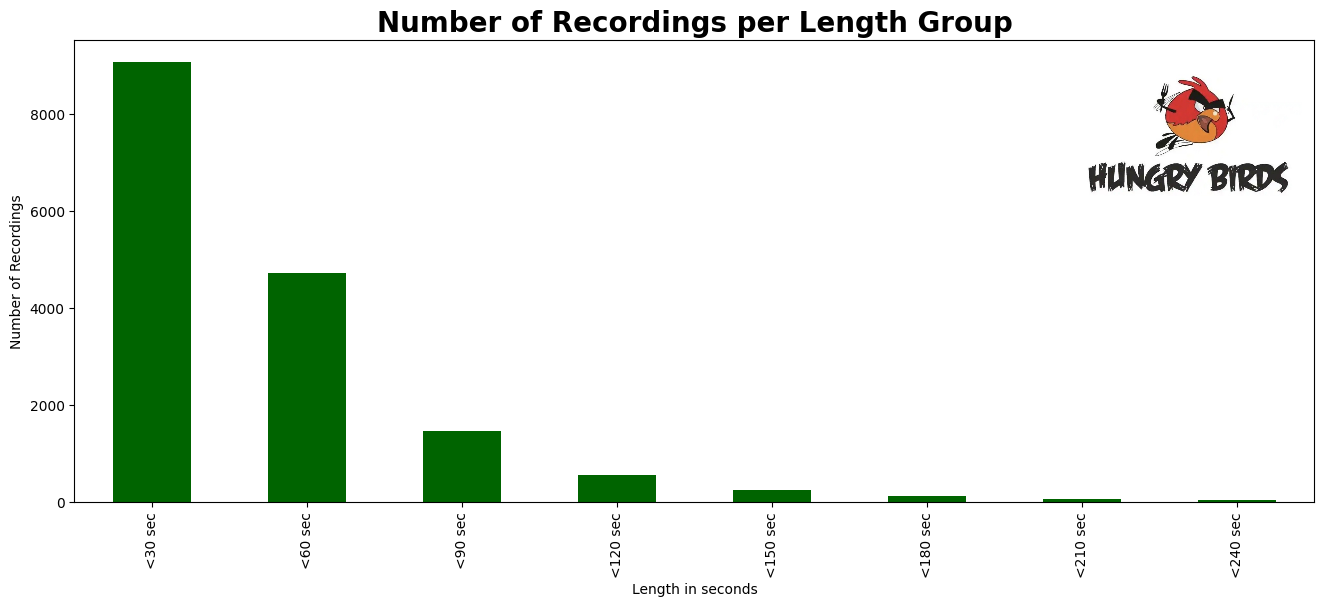

In [22]:
fig, ax = plt.subplots(figsize=(16, 6))
im = OffsetImage(bird, zoom=0.23)
ab = AnnotationBbox(im, xy=(0.90, 0.80), xycoords='axes fraction', frameon=False)
ax.add_artist(ab)

groups = [0, 30, 60, 90, 120, 150, 180, 210, 240]
filtered_df['length_secs'] = filtered_df['length'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))

filtered_df['length_group'] = pd.cut(filtered_df['length_secs'], groups, labels=['<30 sec', '<60 sec', '<90 sec', '<120 sec', '<150 sec', '<180 sec', '<210 sec', '<240 sec'])

length_counts = filtered_df['length_group'].value_counts()

length_counts.plot(kind='bar',color = "darkgreen")

plt.xlabel('Length in seconds')
plt.ylabel('Number of Recordings')
plt.title('Number of Recordings per Length Group', fontsize=20, fontweight='bold')

plt.show()

## Frequency of the recordings

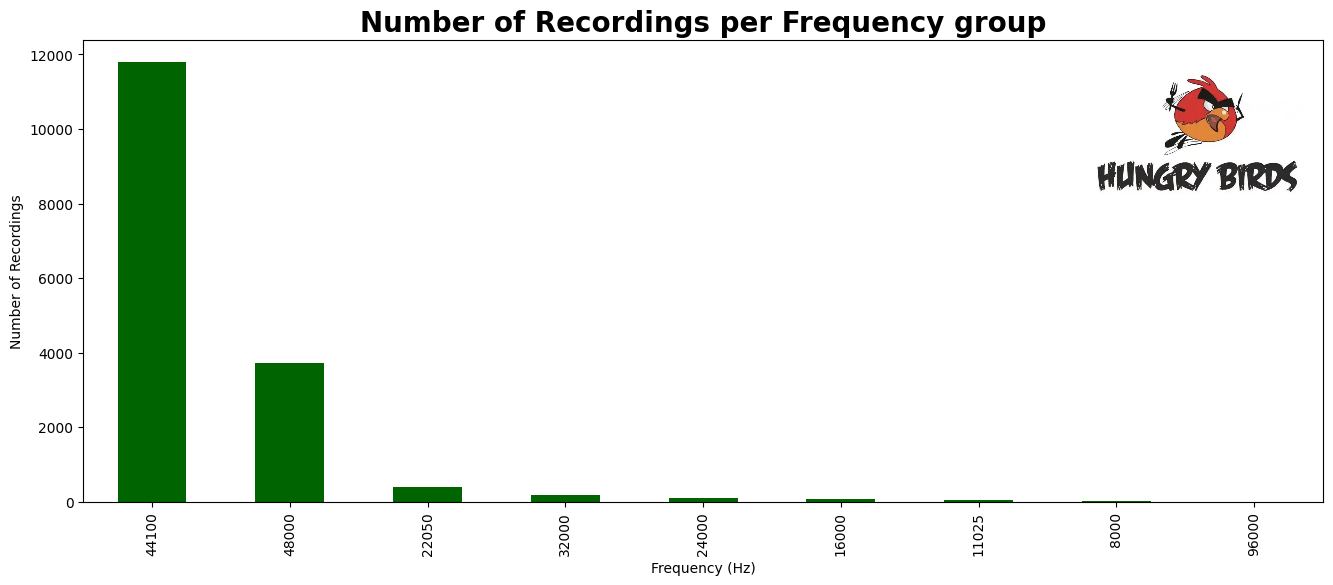

In [23]:
fig, ax = plt.subplots(figsize=(16, 6))
im = OffsetImage(bird, zoom=0.23)
ab = AnnotationBbox(im, xy=(0.90, 0.80), xycoords='axes fraction', frameon=False)
ax.add_artist(ab)

frequency_grouped = filtered_df['smp'].value_counts()

frequency_grouped.plot(kind='bar',color = "darkgreen")

plt.xlabel('Frequency (Hz)')
plt.ylabel('Number of Recordings')
plt.title('Number of Recordings per Frequency group', fontsize=20, fontweight='bold')

plt.show()

**Comment**: The higher the sampling rate (such as 48,000 Hz), the better is the audio quality because it captures more detail in the audio signal. However, the difference in audio quality between 44,100 Hz and 48,000 Hz is generally subtle and may not be noticeable to the average listener.

**Findings**: Some of the sound files are sampled at a sample rate of 48000Hz, while most are sampled at a rate of 44100Hz. This means that 1 second of audio will have an array size of 48000 for some sound files, while it will have a smaller array size of 44100 for the others. We must standardize and convert all audio to the same sampling rate so that all arrays have the same dimensions.

## Types of the recordings

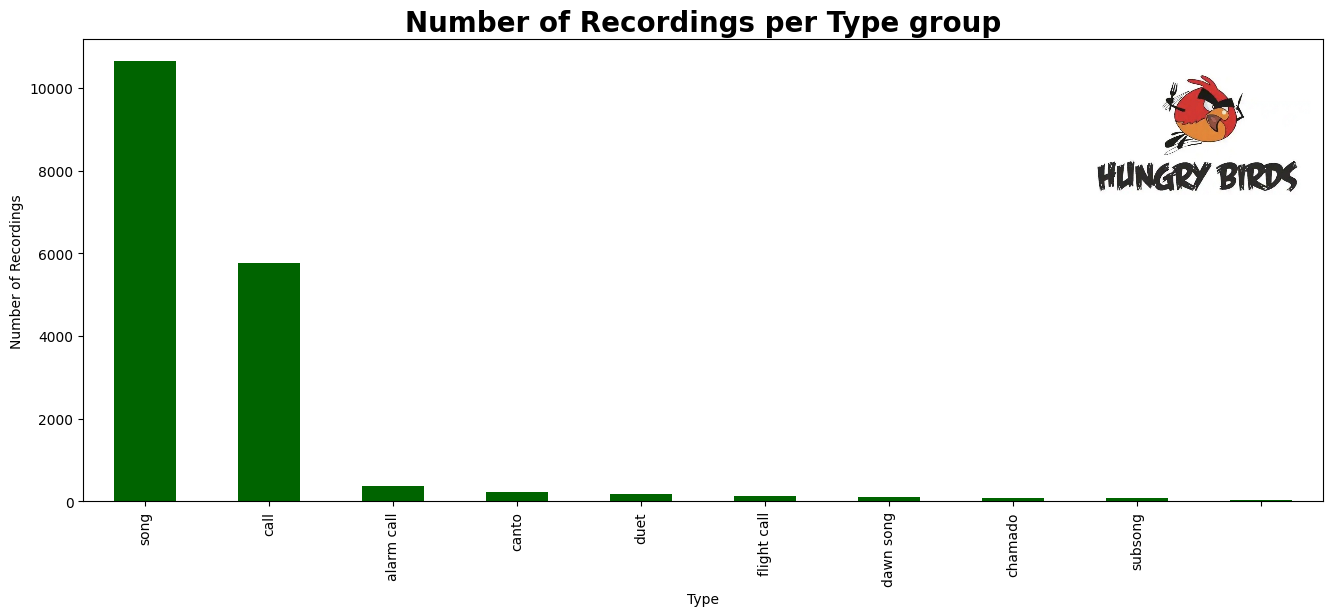

In [24]:
fig, ax = plt.subplots(figsize=(16, 6))
im = OffsetImage(bird, zoom=0.23)
ab = AnnotationBbox(im, xy=(0.90, 0.80), xycoords='axes fraction', frameon=False)
ax.add_artist(ab)

adjusted_type = filtered_df['type'].apply(lambda x: x.split(',')).reset_index().explode("type")

adjusted_type = adjusted_type['type'].apply(lambda x: x.strip().lower()).reset_index()
adjusted_type['type'] = adjusted_type['type'].replace('calls', 'call')

top_10 = list(adjusted_type['type'].value_counts().head(10).reset_index()['index'])
data = adjusted_type[adjusted_type['type'].isin(top_10)]

data_grouped = data['type'].value_counts()

data_grouped.plot(kind='bar',color = "darkgreen")

plt.xlabel('Type')
plt.ylabel('Number of Recordings')
plt.title('Number of Recordings per Type group', fontsize=20, fontweight='bold')

plt.show()

**Comments**:

Calls = used to notify other birds in their flock that a newly discovered food source is nearby.

Songs= used when birds are claiming or protecting their territory or to attract a mate

--> Songs are usually more complex and carry a clear pattern.

## Birds mapping

In [25]:
fig = px.scatter_mapbox(filtered_df, lat='lat', lon='lng', zoom=4, height=800, color='gen_sp')
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Audio files

## Audio file

In [26]:
# Setting Audio path to Aramides Cajaneus's recording #7187
audio_path = '../raw_data/songs/Aramides cajaneus/7187.mp3'

In [27]:
Audio(filename=audio_path)

## Oscillogram (time x amplitude)

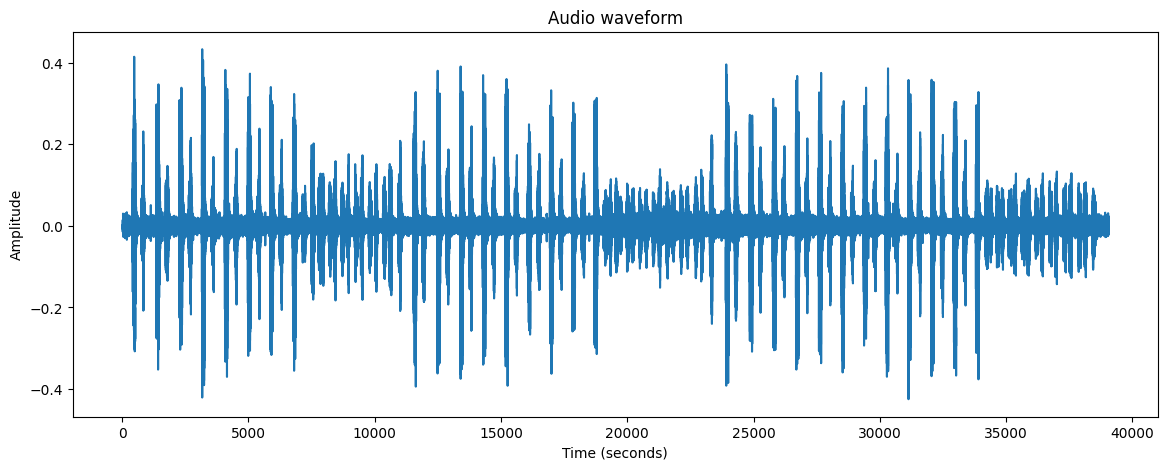

In [28]:
y , sr = librosa.load(audio_path)
time = librosa.times_like(y)

plt.figure(figsize=(14, 5))
plt.plot(time, y)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Audio waveform")
plt.show()

Shows how the amplitude of the signal changes over time

## Spectrogram (time x frequency)

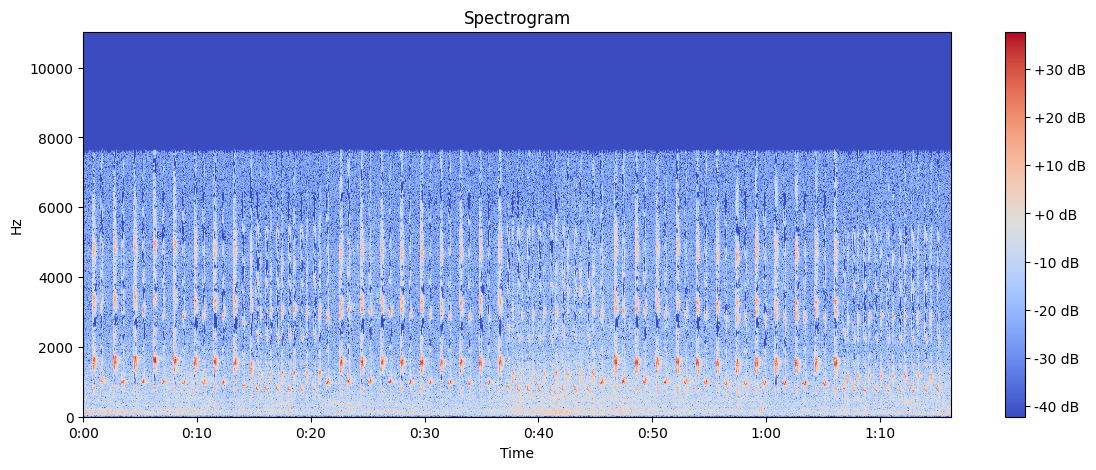

In [29]:
S = librosa.stft(y)
S_db = librosa.amplitude_to_db(abs(S))

plt.figure(figsize=(14, 5))
librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="hz")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram")
plt.show()

Frequency-domain representation of an audio signal

## Mel Spectogram

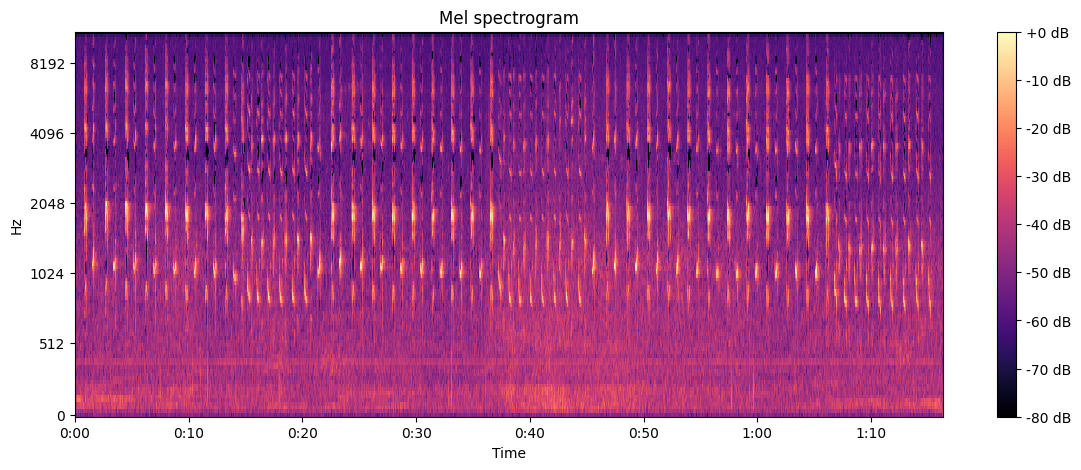

In [30]:
S = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=128, fmax=8000)
S_db = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Mel spectrogram")
plt.show()

A mel spectrogram is a spectrogram which uses a frequency scale. They capture the essential features of the audio and are often the most suitable way to input audio data into deep learning models

Why? Humans are better at detecting differences in lower frequencies than higher frequencies. So, the mel scale is a unit of pitch such that equal distances in pitch sounded equally distant to the listener. 

## Mel spectogram tab

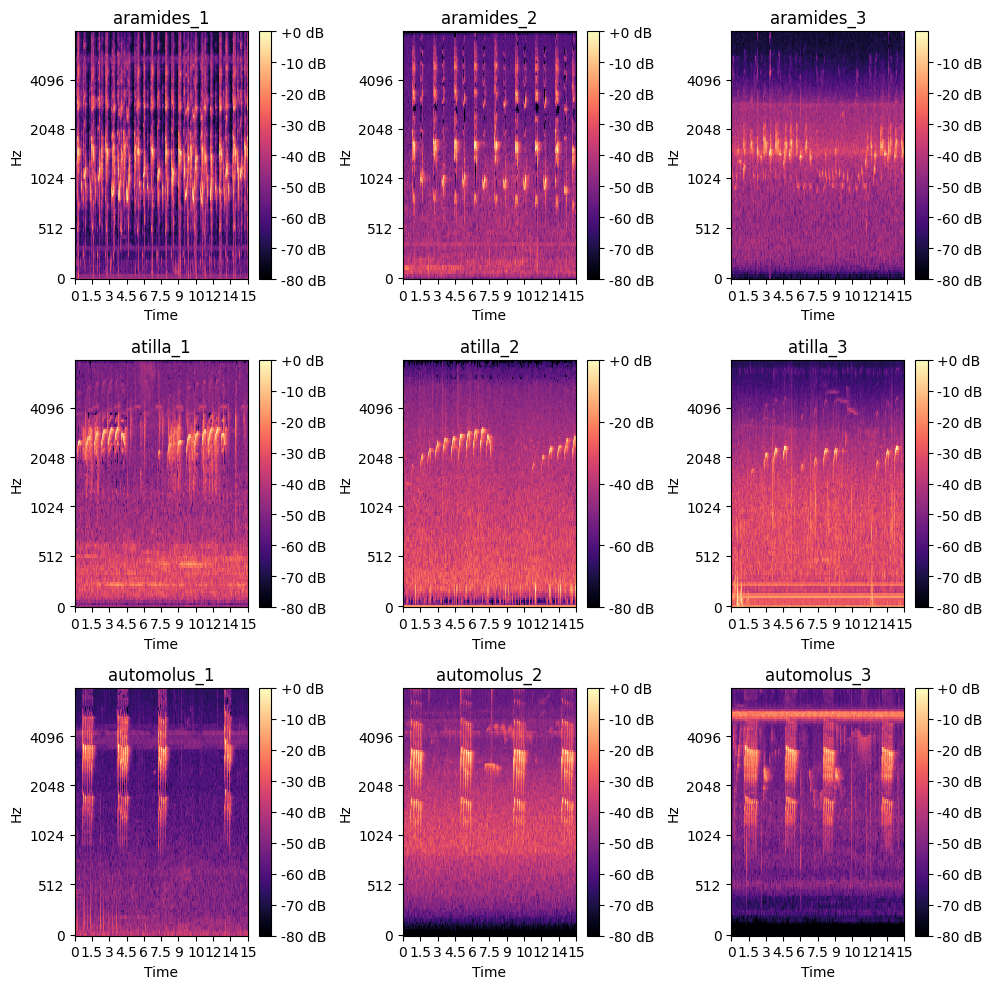

In [31]:
aramides_1='../raw_data/songs/Aramides cajaneus/18517.mp3'
aramides_2 = '../raw_data/songs/Aramides cajaneus/7187.mp3'
aramides_3 = '../raw_data/songs/Aramides cajaneus/7258.mp3'

atilla_1 ='../raw_data/songs/Attila rufus/1509.mp3'
atilla_2 = '../raw_data/songs/Attila rufus/483.mp3'
atilla_3 = '../raw_data/songs/Attila rufus/1318.mp3'

automolus_1 ='../raw_data/songs/Automolus leucophthalmus/463.mp3'
automolus_2 = '../raw_data/songs/Automolus leucophthalmus/34539.mp3'
automolus_3 ='../raw_data/songs/Automolus leucophthalmus/80769.mp3'


filenames = [[aramides_1,aramides_2,aramides_3],[atilla_1,atilla_2,atilla_3],[automolus_1,automolus_2,automolus_3]]

titles = [["aramides_1","aramides_2","aramides_3"],["atilla_1","atilla_2","atilla_3"],["automolus_1","automolus_2","automolus_3"]]
          
# Create 3x3 grid of subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

# Loop through each audio file and plot spectrogram on corresponding subplot
for i in range(3):
    for j in range(3):
        audio_path = filenames[i][j]
        y, sr = librosa.load(audio_path)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        ax = axs[i][j]
        img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                                        y_axis='mel', fmax=8000, x_axis='time', ax=ax)
        axs[i][j].set_title(titles[i][j])
        fig.colorbar(img, ax=ax, format="%+2.0f dB")
        axs[i][j].set_xlim([0, 15])
plt.tight_layout()
plt.show()

**Suggestion**: scale on the same period of time to allow more similariries 